DDPG算法已经收敛，效果还不错。最主要的地方可能是Q神经网络的构建过程中，中间层的实现方式。毕竟是两个输入的。

# 导入函数库

In [8]:
import torch
import gym
import numpy as np
import matplotlib.pyplot as plt

In [9]:
torch.set_default_dtype(torch.float64)

# 经验池

In [10]:
class memory:
  def __init__(self, env, memory_length=20000, memory_minibatch=32):
    self.env = env
    self.memory_length = memory_length
    self.memory_minibatch = memory_minibatch

    self.state_size = self.env.observation_space.shape[0]
    try:self.action_size = self.env.action_space.shape[0]
    except:self.action_size = 1
    
    self.memory_width = self.state_size * 2 + self.action_size + 1
    self.memory = np.zeros((self.memory_length, self.memory_width))

    self.index = 0
    self.max_index = 0

  def store(self, state, action, reward, next_state):
    transacton = np.hstack((state, action, reward, next_state))
    self.memory[self.index,:] = transacton

    self.index += 1
    if self.index % self.memory_length == 0:
      self.index = 0
    if self.max_index < self.memory_length:
      self.max_index += 1
  
  def sample(self):
    choice_random = np.random.choice(self.max_index, self.memory_minibatch)
    choice_data = self.memory[choice_random,:]
    state = choice_data[:,0:self.state_size]
    action = choice_data[:,self.state_size:self.state_size+self.action_size]
    reward = choice_data[:,self.state_size+self.action_size:
                         self.state_size+self.action_size+1]
    next_state = choice_data[:,self.state_size+self.action_size+1:]

    return state, action, reward, next_state


# Critic 网络

In [11]:
class critic:
  def __init__(self, env, hidden_dimension=100, learning_rate=1e-3, gamma=0.9):
    self.env = env
    self.hidden_dimension = hidden_dimension
    self.learning_rate = learning_rate
    self.gamma = gamma

    self.state_dimension = self.env.observation_space.shape[0]
    try:self.action_dimension = self.env.action_space.shape[0]
    except:self.action_dimension = 1

    self.model = self.__create_network()
    self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.learning_rate)


  def __create_network(self):
    class critic_network(torch.nn.Module):
      def __init__(self, state_dimension, action_dimension, hidden_dimension):
        super().__init__()
        self.state_dimension = state_dimension
        self.action_dimension = action_dimension
        self.hidden_dimension = hidden_dimension

        self.layer_state = torch.nn.Linear(self.state_dimension, self.hidden_dimension)
        self.layer_action = torch.nn.Linear(self.action_dimension, self.hidden_dimension)
        self.layer_output = torch.nn.Linear(self.hidden_dimension, 1)
      
      def forward(self, state, action):
        hidden_state = self.layer_state(state)
        hidden_action = self.layer_action(action)
        hidden = hidden_state + hidden_action
        hidden = torch.nn.functional.relu(hidden)
        output = self.layer_output(hidden)
        return output
    return critic_network(self.state_dimension, self.action_dimension, self.hidden_dimension)


# Actor 网络

In [12]:
class actor:
  def __init__(self, env, hidden_dimension=30, learning_rate=1e-3):
    self.env = env
    self.hidden_dimension = hidden_dimension
    self.learning_rate = learning_rate

    self.state_dimension = self.env.observation_space.shape[0]
    self.action_dimension = self.env.action_space.shape[0]
    self.action_bound = [float(self.env.action_space.low), float(self.env.action_space.high)]

    self.model = self.__create_network()
    self.entropy = torch.nn.CrossEntropyLoss(reduction='none')
    self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.learning_rate)

  def __create_network(self):
    class actor_network(torch.nn.Module):
      def __init__(self, state_dimension, action_dimension, action_bound, hidden_dimension):
        super().__init__()
        self.state_dimension = state_dimension
        self.action_dimension = action_dimension
        self.action_bound = action_bound
        self.hidden_dimension = hidden_dimension

        self.layer_state = torch.nn.Linear(self.state_dimension, self.hidden_dimension)
        self.layer_output = torch.nn.Linear(self.hidden_dimension, self.action_dimension)
      
      def forward(self, state):
        hidden = self.layer_state(state)
        hidden = torch.nn.functional.relu(hidden)
        output = self.layer_output(hidden)
        output = torch.tanh(output) * torch.FloatTensor([self.action_bound[1]])
        return output
    return actor_network(self.state_dimension, self.action_dimension,
                   self.action_bound, self.hidden_dimension)

# 智能体交互

In [13]:
class agent_actor_critic:
  def __init__(self, env_name="Pendulum-v0", epoch=1000, gamma=0.9, std=3):
    self.env_name = env_name
    self.epoch = epoch
    self.gamma = gamma
    self.std = 3
    self.env = gym.make(self.env_name)

    self.critic_network = critic(self.env)
    self.actor_network = actor(self.env)
    self.critic_network_target = critic(self.env)
    self.actor_network_target = actor(self.env)
    self.replace_soft(self.critic_network.model, self.critic_network_target.model)
    self.replace_soft(self.actor_network.model, self.actor_network_target.model)
    self.memory = memory(self.env)

  def start_execute(self):
    self.statistic_reward = []
    for i in range(self.epoch):
      state = self.env.reset()
      reward_total = 0
      while True:
        action = self.actor_network.model(torch.from_numpy(state))
        action = torch.clip(torch.normal(action, self.std), 
                             self.actor_network.action_bound[0],
                             self.actor_network.action_bound[1])
        action = np.array(action.tolist())
        next_state, reward, done, info = self.env.step(action)
        self.memory.store(state, action, reward, next_state)
        reward_total += reward
        state = next_state

        loss_actor,loss_critic = -100, -100
        if self.memory.max_index >= self.memory.memory_length:
          # import pdb; pdb.set_trace()
          self.std *= 0.9995
          loss_actor, loss_critic = self.learn()
          self.replace_soft(self.critic_network.model, self.critic_network_target.model)
          self.replace_soft(self.actor_network.model, self.actor_network_target.model)
        if done:
          break
      self.statistic_reward.append(reward_total)
      print(', epoch %-4d, total_reward %s, loss_actor = %s, loss_critic = %s std = %s' \
            %(i, reward_total, loss_actor, loss_critic, self.std))

  def replace_soft(self, network_from, network_to, tau=0.01):
    for target_param, param in zip(network_to.parameters(), network_from.parameters()):
      target_param.data.copy_(
        target_param.data * (1.0 - tau) + param.data * tau
      )

  def learn(self):
    state ,action ,reward, next_state = self.memory.sample()
    state = torch.from_numpy(state)
    action = torch.from_numpy(action)
    reward = torch.from_numpy(reward)
    next_state = torch.from_numpy(next_state)

    next_action = self.actor_network_target.model(next_state).detach()
    next_value = self.critic_network_target.model(next_state, next_action).detach()

    value_target = reward + self.gamma * next_value

    value = self.critic_network.model(state, action)

    loss_critic = torch.nn.functional.mse_loss(value, value_target.detach())
    self.critic_network.optimizer.zero_grad()
    loss_critic.backward()
    self.critic_network.optimizer.step()

    action_value = self.actor_network.model(state)
    loss_actor = -torch.mean(self.critic_network.model(state, action_value))
    self.actor_network.optimizer.zero_grad()
    loss_actor.backward()
    self.actor_network.optimizer.step()

    return loss_actor.tolist(), loss_critic.tolist()


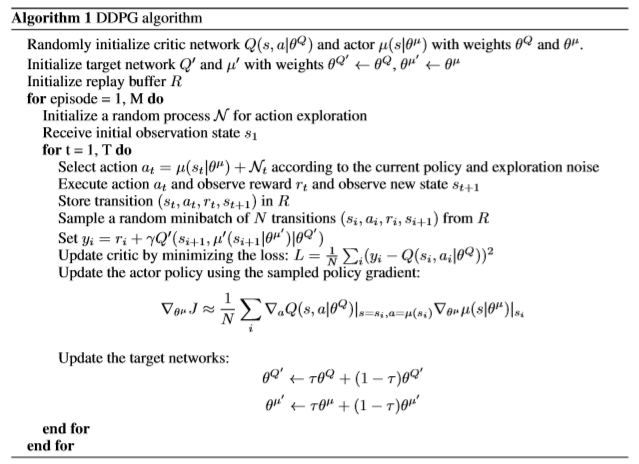

In [14]:
agent_test = agent_actor_critic()
agent_test.start_execute()

, epoch 0   , total_reward -1190.8567773130146, loss_actor = -100, loss_critic = -100 std = 3
, epoch 1   , total_reward -1046.8351129990783, loss_actor = -100, loss_critic = -100 std = 3
, epoch 2   , total_reward -1138.2299933673269, loss_actor = -100, loss_critic = -100 std = 3
, epoch 3   , total_reward -1364.0924163554823, loss_actor = -100, loss_critic = -100 std = 3
, epoch 4   , total_reward -1261.0036094636303, loss_actor = -100, loss_critic = -100 std = 3
, epoch 5   , total_reward -1325.1294428981632, loss_actor = -100, loss_critic = -100 std = 3
, epoch 6   , total_reward -1103.8863100629683, loss_actor = -100, loss_critic = -100 std = 3
, epoch 7   , total_reward -1302.6380402614623, loss_actor = -100, loss_critic = -100 std = 3
, epoch 8   , total_reward -1030.5586192464789, loss_actor = -100, loss_critic = -100 std = 3
, epoch 9   , total_reward -1078.1002385014447, loss_actor = -100, loss_critic = -100 std = 3
, epoch 10  , total_reward -1243.648324166053, loss_actor = 

# 执行交互

In [ ]:
%debug

> /usr/local/lib/python3.7/dist-packages/torch/autograd/__init__.py(147)backward()
    145     Variable._execution_engine.run_backward(
    146         tensors, grad_tensors_, retain_graph, create_graph, inputs,
--> 147         allow_unreachable=True, accumulate_grad=True)  # allow_unreachable flag
    148 
    149 

ipdb> u
> /usr/local/lib/python3.7/dist-packages/torch/tensor.py(245)backward()
    243                 create_graph=create_graph,
    244                 inputs=inputs)
--> 245         torch.autograd.backward(self, gradient, retain_graph, create_graph, inputs=inputs)
    246 
    247     def register_hook(self, hook):

ipdb> u
> <ipython-input-101-fade56d309dd>(67)learn()
     65     loss_critic = torch.nn.functional.mse_loss(value,value_target.detach())
     66     self.critic_network.optimizer.zero_grad()
---> 67     loss_critic.backward()
     68     self.critic_network.optimizer.step()
     69 

ipdb> loss_critic
tensor(69.1889)
ipdb> loss_critic.require_grad
*** Attr

# 测试工具

In [ ]:
! git clone https://github.com/vy007vikas/PyTorch-ActorCriticRL.git

In [ ]:
! python2 ./PyTorch-ActorCriticRL/main.py

In [ ]:
! pip2 install box2d

In [ ]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior
tf.compat.v1.disable_eager_execution()
tf.reset_default_graph()

import numpy as np
import gym
import time
import matplotlib.pyplot as plt

MAX_EPISODES = 200
LR_A = 0.001    # learning rate for actor
LR_C = 0.001    # learning rate for critic
GAMMA = 0.9     # reward discount
REPLACEMENT = [
    dict(name='soft', tau=0.01),
    dict(name='hard', rep_iter_a=600, rep_iter_c=500)
][0]            # you can try different target replacement strategies

MEMORY_CAPACITY = 20000
BATCH_SIZE = 32

ENV_NAME = 'Pendulum-v0'

class Actor(object):
    def __init__(self, sess, action_dim, action_bound, learning_rate, replacement):
        self.sess = sess
        self.a_dim = action_dim
        self.action_bound = action_bound
        self.lr = learning_rate
        self.replacement = replacement
        self.t_replace_counter = 0

        with tf.variable_scope('Actor'):
            self.a = self._build_net(S, scope='eval_net', trainable=True)
            self.a_ = self._build_net(S_, scope='target_net', trainable=False)

        self.e_params = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='Actor/eval_net')
        self.t_params = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='Actor/target_net')

        if self.replacement['name'] == 'hard':
            self.t_replace_counter = 0
            self.hard_replace = [tf.assign(t, e) for t, e in zip(self.t_params, self.e_params)]
        else:
            self.soft_replace = [tf.assign(t, (1 - self.replacement['tau']) * t + self.replacement['tau'] * e)
                                 for t, e in zip(self.t_params, self.e_params)]

    def _build_net(self, s, scope, trainable):
        with tf.variable_scope(scope):
            init_w = tf.random_normal_initializer(0., 0.3)
            init_b = tf.constant_initializer(0.1)
            net = tf.layers.dense(s, 30, activation=tf.nn.relu,
                                  kernel_initializer=init_w, bias_initializer=init_b, name='l1',
                                  trainable=trainable)
            with tf.variable_scope('a'):
                actions = tf.layers.dense(net, self.a_dim, activation=tf.nn.tanh, kernel_initializer=init_w,
                                          bias_initializer=init_b, name='a', trainable=trainable)
                scaled_a = tf.multiply(actions, self.action_bound, name='scaled_a')  # Scale output to -action_bound to action_bound
        return scaled_a

    def learn(self, s):   # batch update
        self.sess.run(self.train_op, feed_dict={S: s})
        if self.replacement['name'] == 'soft':
            self.sess.run(self.soft_replace)
        else:
            if self.t_replace_counter % self.replacement['rep_iter_a'] == 0:
                self.sess.run(self.hard_replace)
            self.t_replace_counter += 1

    def choose_action(self, s):
        s = s[np.newaxis, :]    # single state
        return self.sess.run(self.a, feed_dict={S: s})[0]  # single action

    def add_grad_to_graph(self, a_grads):
        with tf.variable_scope('policy_grads'):
            # ys = policy;
            # xs = policy's parameters;
            # a_grads = the gradients of the policy to get more Q
            # tf.gradients will calculate dys/dxs with a initial gradients for ys, so this is dq/da * da/dparams
            self.policy_grads = tf.gradients(ys=self.a, xs=self.e_params, grad_ys=a_grads)

        with tf.variable_scope('A_train'):
            opt = tf.train.AdamOptimizer(-self.lr)  # (- learning rate) for ascent policy
            self.train_op = opt.apply_gradients(zip(self.policy_grads, self.e_params))

class Critic(object):
    def __init__(self, sess, state_dim, action_dim, learning_rate, gamma, replacement, a, a_):
        self.sess = sess
        self.s_dim = state_dim
        self.a_dim = action_dim
        self.lr = learning_rate
        self.gamma = gamma
        self.replacement = replacement

        with tf.variable_scope('Critic'):
            # Input (s, a), output q
            self.a = tf.stop_gradient(a)    # stop critic update flows to actor
            self.q = self._build_net(S, self.a, 'eval_net', trainable=True)
            self.q_ = self._build_net(S_, a_, 'target_net', trainable=False)    # target_q is based on a_ from Actor's target_net

            self.e_params = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='Critic/eval_net')
            self.t_params = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='Critic/target_net')

        with tf.variable_scope('target_q'):
            self.target_q = R + self.gamma * self.q_
        with tf.variable_scope('TD_error'):
            self.loss = tf.reduce_mean(tf.squared_difference(self.target_q, self.q))
        with tf.variable_scope('C_train'):
            self.train_op = tf.train.AdamOptimizer(self.lr).minimize(self.loss)
        with tf.variable_scope('a_grad'):
            self.a_grads = tf.gradients(self.q, self.a)[0]   # tensor of gradients of each sample (None, a_dim)
        if self.replacement['name'] == 'hard':
            self.t_replace_counter = 0
            self.hard_replacement = [tf.assign(t, e) for t, e in zip(self.t_params, self.e_params)]
        else:
            self.soft_replacement = [tf.assign(t, (1 - self.replacement['tau']) * t + self.replacement['tau'] * e)
                                     for t, e in zip(self.t_params, self.e_params)]

    def _build_net(self, s, a, scope, trainable):
        with tf.variable_scope(scope):
            init_w = tf.random_normal_initializer(0., 0.1)
            init_b = tf.constant_initializer(0.1)

            with tf.variable_scope('l1'):
                n_l1 = 30
                w1_s = tf.get_variable('w1_s', [self.s_dim, n_l1], initializer=init_w, trainable=trainable)
                w1_a = tf.get_variable('w1_a', [self.a_dim, n_l1], initializer=init_w, trainable=trainable)
                b1 = tf.get_variable('b1', [1, n_l1], initializer=init_b, trainable=trainable)
                net = tf.nn.relu(tf.matmul(s, w1_s) + tf.matmul(a, w1_a) + b1)

            with tf.variable_scope('q'):
                q = tf.layers.dense(net, 1, kernel_initializer=init_w, bias_initializer=init_b, trainable=trainable)   # Q(s,a)
        return q

    def learn(self, s, a, r, s_):
        self.sess.run(self.train_op, feed_dict={S: s, self.a: a, R: r, S_: s_})
        if self.replacement['name'] == 'soft':
            self.sess.run(self.soft_replacement)
        else:
            if self.t_replace_counter % self.replacement['rep_iter_c'] == 0:
                self.sess.run(self.hard_replacement)
            self.t_replace_counter += 1

class Memory(object):
    def __init__(self, capacity, dims):
        self.capacity = capacity
        self.data = np.zeros((capacity, dims))
        self.pointer = 0

    def store_transition(self, s, a, r, s_):
        transition = np.hstack((s, a, [r], s_))
        index = self.pointer % self.capacity  # replace the old memory with new memory
        self.data[index, :] = transition
        self.pointer += 1

    def sample(self, n):
        assert self.pointer >= self.capacity, 'Memory has not been fulfilled'
        indices = np.random.choice(self.capacity, size=n)
        return self.data[indices, :]


env = gym.make(ENV_NAME)

state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]
action_bound = env.action_space.high

# all placeholder for tf
with tf.name_scope('S'):
    S = tf.placeholder(tf.float32, shape=[None, state_dim], name='s')
with tf.name_scope('R'):
    R = tf.placeholder(tf.float32, [None, 1], name='r')
with tf.name_scope('S_'):
    S_ = tf.placeholder(tf.float32, shape=[None, state_dim], name='s_')


sess = tf.Session()

# Create actor and critic.
# They are actually connected to each other, details can be seen in tensorboard or in this picture:
actor = Actor(sess, action_dim, action_bound, LR_A, REPLACEMENT)
critic = Critic(sess, state_dim, action_dim, LR_C, GAMMA, REPLACEMENT, actor.a, actor.a_)
actor.add_grad_to_graph(critic.a_grads)

sess.run(tf.global_variables_initializer())

M = Memory(MEMORY_CAPACITY, dims=2 * state_dim + action_dim + 1)

var = 3  # control exploration

reward_array = []
for i in range(MAX_EPISODES):
    s = env.reset()
    ep_reward = 0

    while True:
        a = actor.choose_action(s)
        a = np.clip(np.random.normal(a, var), -2, 2)    # add randomness to action selection for exploration
        s_, r, done, info = env.step(a)

        M.store_transition(s, a, r, s_)

        if M.pointer > MEMORY_CAPACITY:
            var *= .9995    # decay the action randomness
            b_M = M.sample(BATCH_SIZE)
            b_s = b_M[:, :state_dim]
            b_a = b_M[:, state_dim: state_dim + action_dim]
            b_r = b_M[:, -state_dim - 1: -state_dim]
            b_s_ = b_M[:, -state_dim:]

            critic.learn(b_s, b_a, b_r, b_s_)
            actor.learn(b_s)

        s = s_
        ep_reward += r

        if done:
            print('Episode:', i, ' Reward: %i' % int(ep_reward), 'Explore: %.2f' % var, )
            reward_array.append(ep_reward)
            s = env.reset()
            break
plot_array(reward_array,'episode','total_reward')
print('Running time: ', time.time()-t1)

# 测试工具2

In [ ]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior
tf.compat.v1.disable_eager_execution()
tf.reset_default_graph()
import numpy as np
import gym
import time

MAX_EPISODES = 2000
MAX_EP_STEPS = 200
LR_A = 0.001    # learning rate for actor
LR_C = 0.002    # learning rate for critic
GAMMA = 0.9     # reward discount
TAU = 0.01      # soft replacement
MEMORY_CAPACITY = 10000
BATCH_SIZE = 32

ENV_NAME = 'Pendulum-v0'

class DDPG(object):
    def __init__(self, a_dim, s_dim, a_bound,):
        self.memory = np.zeros((MEMORY_CAPACITY, s_dim * 2 + a_dim + 1), dtype=np.float32)
        self.pointer = 0
        self.sess = tf.Session()

        self.a_dim, self.s_dim, self.a_bound = a_dim, s_dim, a_bound,
        self.S = tf.placeholder(tf.float32, [None, s_dim], 's')
        self.S_ = tf.placeholder(tf.float32, [None, s_dim], 's_')
        self.R = tf.placeholder(tf.float32, [None, 1], 'r')

        with tf.variable_scope('Actor'):
            self.a = self._build_a(self.S, scope='eval', trainable=True)
            a_ = self._build_a(self.S_, scope='target', trainable=False)
        with tf.variable_scope('Critic'):
            # assign self.a = a in memory when calculating q for td_error,
            # otherwise the self.a is from Actor when updating Actor
            q = self._build_c(self.S, self.a, scope='eval', trainable=True)
            q_ = self._build_c(self.S_, a_, scope='target', trainable=False)

        # networks parameters
        self.ae_params = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='Actor/eval')
        self.at_params = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='Actor/target')
        self.ce_params = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='Critic/eval')
        self.ct_params = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='Critic/target')

        # target net replacement
        self.soft_replace = [tf.assign(t, (1 - TAU) * t + TAU * e)
                             for t, e in zip(self.at_params + self.ct_params, self.ae_params + self.ce_params)]

        q_target = self.R + GAMMA * q_
        # in the feed_dic for the td_error, the self.a should change to actions in memory
        td_error = tf.losses.mean_squared_error(labels=q_target, predictions=q)
        self.ctrain = tf.train.AdamOptimizer(LR_C).minimize(td_error, var_list=self.ce_params)

        a_loss = - tf.reduce_mean(q)    # maximize the q
        self.atrain = tf.train.AdamOptimizer(LR_A).minimize(a_loss, var_list=self.ae_params)

        self.sess.run(tf.global_variables_initializer())

    def choose_action(self, s):
        return self.sess.run(self.a, {self.S: s[np.newaxis, :]})[0]

    def learn(self):
        # soft target replacement
        self.sess.run(self.soft_replace)

        indices = np.random.choice(MEMORY_CAPACITY, size=BATCH_SIZE)
        bt = self.memory[indices, :]
        bs = bt[:, :self.s_dim]
        ba = bt[:, self.s_dim: self.s_dim + self.a_dim]
        br = bt[:, -self.s_dim - 1: -self.s_dim]
        bs_ = bt[:, -self.s_dim:]

        self.sess.run(self.atrain, {self.S: bs})
        self.sess.run(self.ctrain, {self.S: bs, self.a: ba, self.R: br, self.S_: bs_})

    def store_transition(self, s, a, r, s_):
        transition = np.hstack((s, a, [r], s_))
        index = self.pointer % MEMORY_CAPACITY  # replace the old memory with new memory
        self.memory[index, :] = transition
        self.pointer += 1

    def _build_a(self, s, scope, trainable):
        with tf.variable_scope(scope):
            net = tf.layers.dense(s, 30, activation=tf.nn.relu, name='l1', trainable=trainable)
            a = tf.layers.dense(net, self.a_dim, activation=tf.nn.tanh, name='a', trainable=trainable)
            return tf.multiply(a, self.a_bound, name='scaled_a')

    def _build_c(self, s, a, scope, trainable):
        with tf.variable_scope(scope):
            n_l1 = 30
            w1_s = tf.get_variable('w1_s', [self.s_dim, n_l1], trainable=trainable)
            w1_a = tf.get_variable('w1_a', [self.a_dim, n_l1], trainable=trainable)
            b1 = tf.get_variable('b1', [1, n_l1], trainable=trainable)
            net = tf.nn.relu(tf.matmul(s, w1_s) + tf.matmul(a, w1_a) + b1)
            return tf.layers.dense(net, 1, trainable=trainable)  # Q(s,a)

###############################  training  ####################################

env = gym.make(ENV_NAME)
env = env.unwrapped
env.seed(1)

s_dim = env.observation_space.shape[0]
a_dim = env.action_space.shape[0]
a_bound = env.action_space.high

ddpg = DDPG(a_dim, s_dim, a_bound)

var = 3  # control exploration
t1 = time.time()
for episode in range(MAX_EPISODES):
    s = env.reset()
    ep_reward = 0
    for j in range(MAX_EP_STEPS):
        if RENDER:
            env.render()

        # Add exploration noise
        a = ddpg.choose_action(s)
        a = np.clip(np.random.normal(a, var), -2, 2)    # add randomness to action selection for exploration
        s_, r, done, info = env.step(a)

        ddpg.store_transition(s, a, r / 10, s_)

        if ddpg.pointer > MEMORY_CAPACITY:
            var *= .9995    # decay the action randomness
            ddpg.learn()

        s = s_
        ep_reward += r
        if j == MAX_EP_STEPS-1:
            print('Episode:', episode, ' Reward: %i' % int(ep_reward), 'Explore: %.2f' % var, )
            # if ep_reward > -300:RENDER = True
            break
    if episode % 100 == 0:
      total_reward = 0
      for i in range(10):
        state = env.reset()
        for j in range(MAX_EP_STEPS):

          action = ddpg.choose_action(state) # direct action for test
          state,reward,done,_ = env.step(action)
          total_reward += reward
          if done:
            break
      ave_reward = total_reward/300
      print ('episode: ',episode,'Evaluation Average Reward:',ave_reward)
print('Running time: ', time.time() - t1)